In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [ ]:
sc.stop()

In [3]:

sc = SparkContext('local')
#Hacer sc.stop() despues
spark = SparkSession(sc)

q ="""{
     "query": {
       "match_all": {}
     }  
}"""


df_wifi = spark.read.format("es").option("es.query", q).load("wifi")
df_firewall = spark.read.format("es").option("es.query", q).load("firewall")





In [ ]:
df_wifi.head(2)

In [ ]:
df_wifi.printSchema()

In [4]:
from pyspark.ml.feature import StringIndexer

for column in ["address", 
               "auth",
               "caps",
               "cipher",
               "essid",
               "event",
               "id",
               "oui",
               "prediction",
               "secur",
               "type",
               "version"]:
    indexer = StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_wifi)
    df_wifi = indexer.setHandleInvalid("skip").transform(df_wifi)
    df_wifi = df_wifi.drop(column)


In [5]:
df_wifi.printSchema()

root
 |-- channel: long (nullable = true)
 |-- power: long (nullable = true)
 |-- rx_bytes: long (nullable = true)
 |-- rx_packets: long (nullable = true)
 |-- time_stamp: long (nullable = true)
 |-- tx_bytes: long (nullable = true)
 |-- tx_packets: long (nullable = true)
 |-- address_index: double (nullable = false)
 |-- auth_index: double (nullable = false)
 |-- caps_index: double (nullable = false)
 |-- cipher_index: double (nullable = false)
 |-- essid_index: double (nullable = false)
 |-- event_index: double (nullable = false)
 |-- id_index: double (nullable = false)
 |-- oui_index: double (nullable = false)
 |-- prediction_index: double (nullable = false)
 |-- secur_index: double (nullable = false)
 |-- type_index: double (nullable = false)
 |-- version_index: double (nullable = false)



In [ ]:
df_wifi.describe().show()

In [13]:
print("wifi events:", df_wifi.count())
#print("firewall events:", df_firewall.count())

wifi events: 123453


In [ ]:
df_firewall.printSchema()

In [15]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_wifi.columns, outputCol=vector_col)
df_vector = assembler.transform(df_wifi).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

AttributeError: 'str' object has no attribute 'show'

In [12]:
print("Pearson correlation matrix:\n" + str(matrix[0]))


Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  3.54708845e-01, -1.81918983e-02,
              -3.90998725e-02,  9.85747490e-03, -1.76214678e-02,
              -3.77524193e-02, -1.02586904e-02, -5.91193853e-02,
               1.40096285e-02, -4.98075169e-02, -1.13542992e-01,
                          nan,             nan, -1.12532760e-01,
              -2.50286235e-03, -9.57827596e-02,             nan,
                          nan],
             [ 3.54708845e-01,  1.00000000e+00,  8.27280510e-02,
               1.16959133e-01, -9.84750399e-04,  1.28255715e-01,
               1.71961724e-01, -1.03398855e-01,  1.35946892e-01,
               5.29661110e-02,  1.68163388e-01, -1.53266800e-01,
                          nan,             nan, -8.25495334e-03,
               4.34259484e-04,  3.20597957e-02,             nan,
                          nan],
             [-1.81918983e-02,  8.27280510e-02,  1.00000000e+00,
               6.19792534e-01,  8.48230633e-04,  3.51165991e-01

In [16]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [17]:
corrmatrix

[[1.0,
  0.35470884495441424,
  -0.018191898283569593,
  -0.039099872516613246,
  0.009857474900278473,
  -0.01762146778801827,
  -0.037752419281284214,
  -0.010258690407430058,
  -0.05911938529674284,
  0.014009628548822846,
  -0.049807516936450476,
  -0.11354299187246535,
  nan,
  nan,
  -0.11253275994555861,
  -0.0025028623523439997,
  -0.09578275957203895,
  nan,
  nan],
 [0.35470884495441424,
  1.0,
  0.0827280510042746,
  0.11695913267555502,
  -0.0009847503992118606,
  0.12825571548011258,
  0.17196172390462117,
  -0.10339885505025431,
  0.13594689186511705,
  0.05296611096193632,
  0.16816338837173678,
  -0.15326679997245496,
  nan,
  nan,
  -0.008254953340937048,
  0.00043425948406004475,
  0.03205979566888395,
  nan,
  nan],
 [-0.018191898283569593,
  0.0827280510042746,
  1.0,
  0.6197925335764858,
  0.0008482306333709341,
  0.35116599121669023,
  0.2953074829753299,
  -0.03526687445293116,
  0.001630747859103209,
  0.03476284258372381,
  0.008685104006071379,
  -0.035118079

In [55]:
import matplotlib.pyplot as plt
import numpy as np
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    #ax.set_xticks(np.arange(len(attr)))
    #ax.set_yticks(np.arange(len(attr)))
    ax.set_xticklabels(attr)
    ax.set_yticklabels(attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()



19


/home/vagrant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/vagrant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


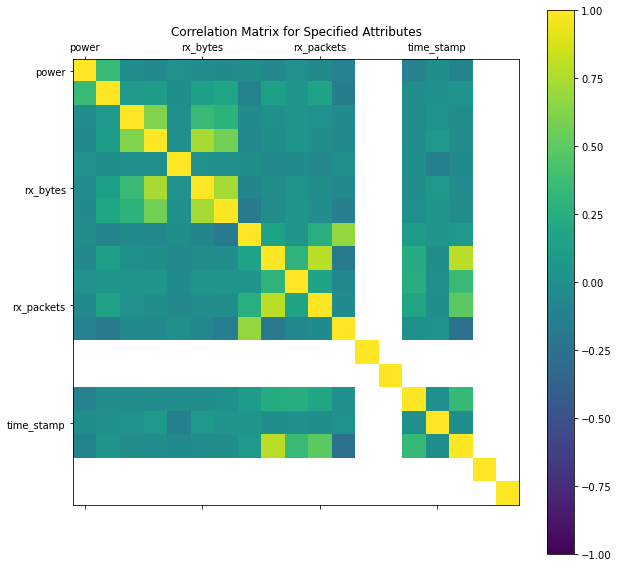

In [56]:
columns = df_wifi.columns
print(len(columns))
plot_corr_matrix(corrmatrix, columns, 234)